In [ ]:
!pip install kaggle -q
!pip install wandb -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.1 MB/s eta 0:00:00


In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
%%bash
gdown --id 18LusyPD-hERgBhIzsYJPmz8OYD6wmv5k -q
mkdir /root/.kaggle
mv kaggle.json /root/.kaggle/
kaggle datasets download alxmamaev/flowers-recognition
unzip -q flowers-recognition.zip -d dataset
rm flowers-recognition.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
100%|██████████| 225M/225M [00:01<00:00, 119MB/s]


In [ ]:
import os
import shutil
import torch
import torch.nn as nn
import numpy as np
from glob import glob

import copy
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms as T
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

dataset = ImageFolder(
    './dataset/flowers',
    transform=transform
)

train_set, val_set, test_set = torch.utils.data.random_split(
    dataset,
    [.8, .1, .1]
)


In [ ]:
names = ['Train', 'Validation', 'Test']
sets = [train_set, val_set, test_set]
for name, set_ in zip(names, sets):
  print(name, len(set_))

Train 3454
Validation 432
Test 431


In [ ]:
from collections import Counter

names = ['Train', 'Validation', 'Test']
sets = [train_set, val_set, test_set]
for name, set_ in zip(names, sets):
  counter = Counter([label for _, label in set_])
  print(name)
  for label, count in counter.items():
    print(f'\t{label}: {count / len(set_):.2f}')
  print('\n------------------------------------\n')

Train
	4: 0.23
	0: 0.18
	2: 0.18
	1: 0.25
	3: 0.17

------------------------------------

Validation
	2: 0.18
	4: 0.25
	0: 0.18
	1: 0.25
	3: 0.14

------------------------------------

Test
	0: 0.19
	1: 0.23
	2: 0.18
	4: 0.21
	3: 0.19

------------------------------------



In [ ]:
train_set[1][0].shape, train_set[0][0].shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [ ]:
train_loader = DataLoader(
    train_set,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=8
)

val_loader = DataLoader(
    val_set,
    batch_size=128,
    shuffle=True,
    pin_memory=True,
    num_workers=8
)

test_loader = DataLoader(
    train_set,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=8
)

In [ ]:
from IPython.display import clear_output

def plot(train_losses, validation_losses, train_accuracies, validation_accuracies):
  clear_output()
  fig, ax = plt.subplots(1, 2, figsize=(10, 6))
  ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='train', c='r')
  ax[0].plot(range(1, len(validation_losses) + 1), validation_losses, label='validation', c='b')
  ax[0].set_ylabel('Cross-Entropy Loss')
  ax[1].plot(range(1, len(train_accuracies) + 1), train_accuracies, label='train', c='r')
  ax[1].plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='validation', c='b')
  ax[1].set_ylabel('Accuracy')
  for ax_ in ax:
    ax_.set_xlabel('Epochs')
    ax_.legend()

  plt.show()

In [ ]:
def train_epoch(model, optimizer, criterion, train_loader, device, epoch, desc='Training'):
  model.train()
  real_loss, accuracy = .0, .0
  count = 0
  for images, labels in tqdm(train_loader, desc=desc):
    optimizer.zero_grad()

    images = images.to(device)
    labels = labels.to(device)

    prediction = model(images)
    loss = criterion(prediction, labels)
    loss.backward()
    optimizer.step()
    real_loss += loss.cpu().item()
    accuracy += (torch.argmax(prediction.cpu(), dim=1) == labels.cpu()).sum().item()
    count += len(images)

  wandb.log({
    'train/train_loss': real_loss / count,
    'train/train_accuracy': accuracy / count,
    'train/epoch': epoch
  })

  return real_loss / count, accuracy / count

@torch.no_grad()
def test_epoch(model, criterion, test_loader, device, epoch, desc='Testing'):
  model.eval()
  real_loss, accuracy = .0, .0
  count = 0
  for images, labels in tqdm(train_loader, desc=desc):
    images = images.to(device)
    labels = labels.to(device)

    prediction = model(images)
    loss = criterion(prediction, labels)
    real_loss += loss.cpu().item()
    accuracy += (torch.argmax(prediction.cpu(), dim=1) == labels.cpu()).sum().item()
    count += len(images)

  wandb.log({
    'test/test_loss': real_loss / count,
    'test/test_accuracy': accuracy / count,
    'test/epoch': epoch
  })

  return real_loss / count, accuracy / count


def train(model, optimizer, criterion, train_loader, val_loader, device, num_epochs=20, patience=None, scheduler=None):
  train_losses, validation_losses, train_accuracies, validation_accuracies = [], [], [], []
  the_best_val_loss, the_best_epoch = None, None
  the_best_model = None

  for epoch in range(1, num_epochs + 1):
    train_loss, train_accuracy = train_epoch(
        model, optimizer, criterion, train_loader, device, epoch, desc=f'Train {epoch} / {num_epochs}'
    )
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    if scheduler:
      scheduler.step()

    validation_loss, validation_accuracy = test_epoch(
        model, criterion, val_loader, device, epoch, desc=f'Validation {epoch} / {num_epochs}'
    )
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    plot(train_losses, validation_losses, train_accuracies, validation_accuracies)

    if patience:
      if (the_best_val_loss is None) or (the_best_val_loss > validation_loss):
        the_best_val_loss = validation_loss
        the_best_epoch = epoch
        the_best_model = copy.deepcopy(model)

      if epoch - the_best_epoch > patience:
        print('The model has not improved after last {patience} epochs. The procedure is interrupted...')
        model = the_best_model
        break

  torch.save({
      'model': model.state_dict(),
      'optimizer': optimizer.state_dict()
  }, 'model.pt')
  print('The model was saved to the file "model.pt"')

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
#for p in model.parameters():
#  p.requires_grad = False

model.fc = nn.Linear(in_features, len(dataset.classes))

In [ ]:
NUM_EPOCHS = 20
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)
criterion = nn.CrossEntropyLoss(reduction='sum')

wandb.init(
    project='FlowersRecognition',
    name='Resnet50(pretrained=True)|transform=[T.Resize(224, 224), ToTensor]',
    config={
        'epochs': NUM_EPOCHS,
        'model': 'resnet50',
        'backbone_pretrained': True,
        'froze_backbone': False,
        'transform': '[T.Resize(224, 224), ToTensor]',
        'batch_size': 32,
        'lr': 1e-3,
        'scheduler': 'Cosine'
    }
)

test/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██▁
test/test_accuracy,▁▁▄▃▅▅▅▆▆▇▇▇▇▇█▇█████
test/test_loss,█▆▄▅▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train/epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
train/train_accuracy,▁▅▆▆▆▇▇▇▇▇▇▇█▇▇█████
train/train_loss,█▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
test/epoch,1
test/test_accuracy,0.95628
test/test_loss,0.15152
train/epoch,20
train/train_accuracy,0.94065


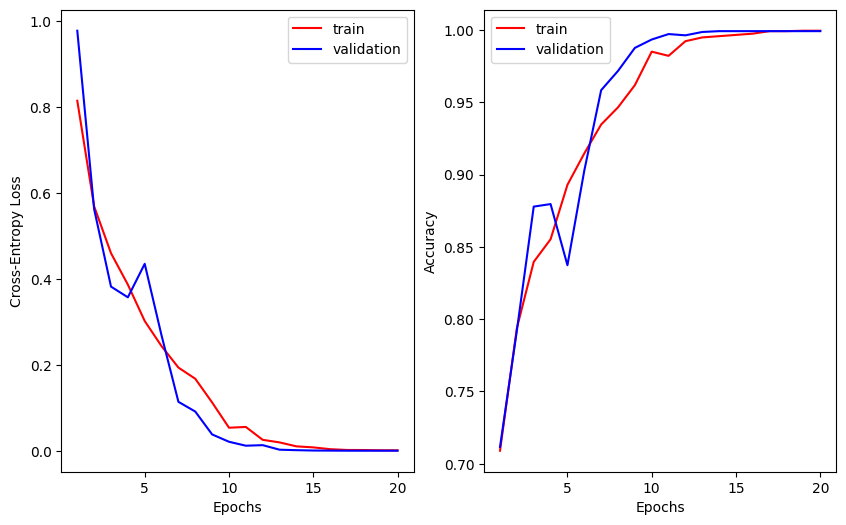

The model was saved to the file "model.pt"


In [ ]:
train(
    model,
    optimizer,
    criterion,
    train_loader,
    val_loader,
    device,
    num_epochs=NUM_EPOCHS,
    patience=5,
    scheduler=scheduler
)

In [ ]:
test_epoch(model, criterion, test_loader, device, 1, desc='Testing')

Testing:   0%|          | 0/108 [00:00<?, ?it/s]

(0.0013855236487613574, 0.9991314418066011)

In [ ]:
torch.cuda.empty_cache()
with torch.no_grad():
  torch.cuda.empty_cache()

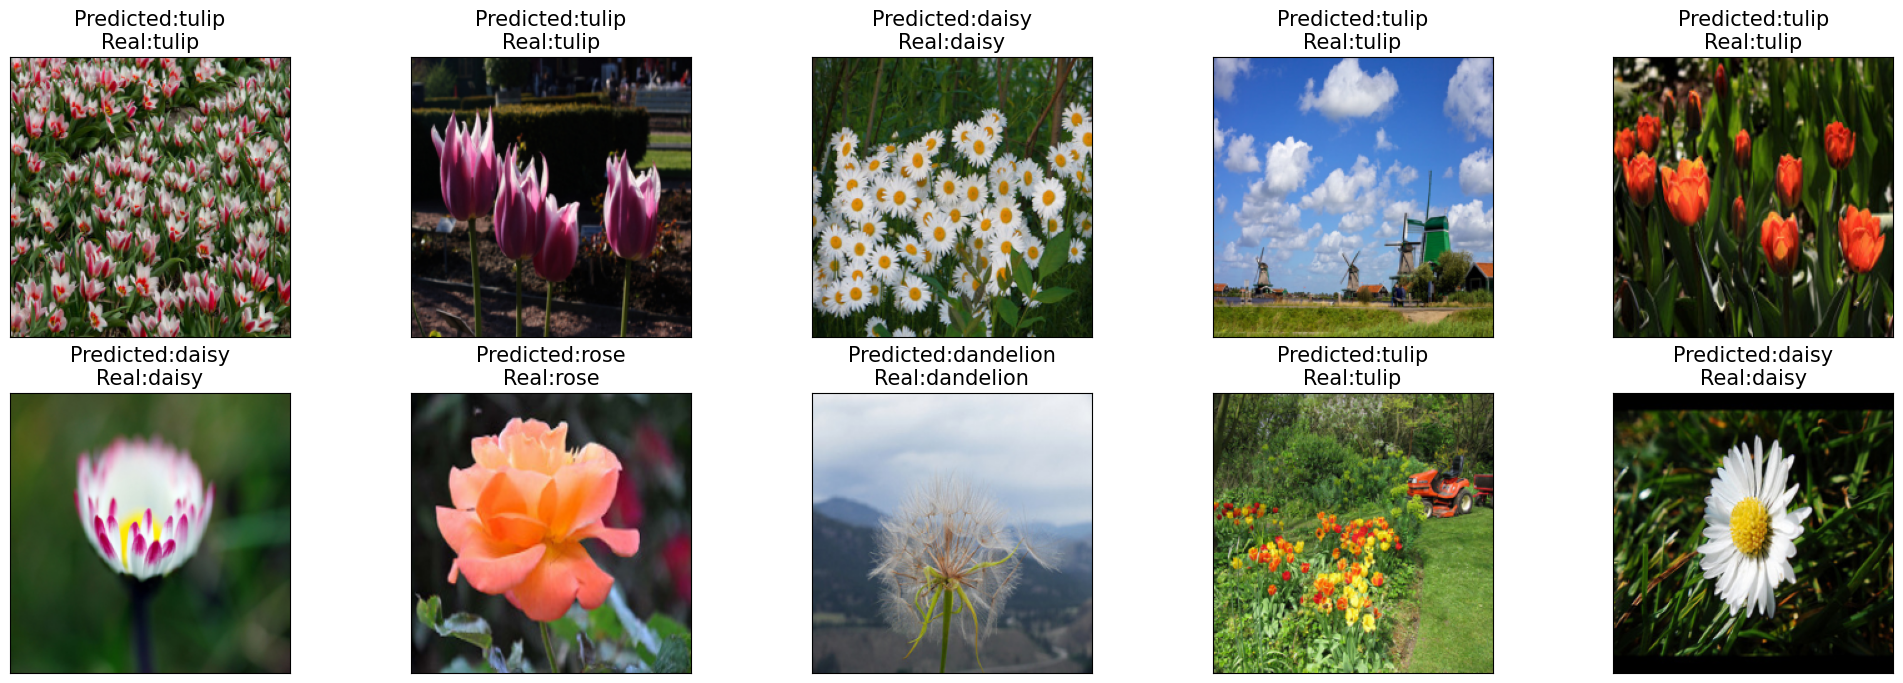

In [ ]:
images, labels = next(iter(test_loader))
with torch.no_grad():
  results = torch.argmax(model(images.to(device)), dim=1).cpu()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 8))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(
        'Predicted:{predicted}\nReal:{real}'.format(
            real=dataset.classes[labels[idx]],
            predicted=dataset.classes[results[idx]]
        ),
        fontsize=15)